In [2]:
import connectorx as cx
import pandas as pd
import numpy as np
import os
import duckdb
from datetime import datetime
import glob
import multiprocessing as mp
from functools import partial
import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [12]:
df = pd.read_parquet("/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Bid_percent_minute_level_APB/20210518.parquet")
df['datetime'] = pd.to_datetime(df['order_minute'])
df['start_time'] = df['datetime'].dt.hour * 100 + df['datetime'].dt.minute


minute_df = df[['date','security_code','start_time','apb_p01_p99']]
minute_df = minute_df.rename(columns={'date': 'trading_day'})
minute_df['start_time'] = minute_df['start_time'].astype(int)
minute_df['security_code'] = minute_df['security_code'].astype(str)
minute_df['trading_day'] = pd.to_datetime(minute_df['trading_day'])


minute_ret = pd.read_parquet("/data/cephfs/minute/one_minute/20210518.parquet")
minute_ret = minute_ret[['security_code','trading_day','start_time','minute_return']]
minute_ret['start_time'] = minute_ret['start_time'].astype(int)
minute_ret['security_code'] = minute_ret['security_code'].astype(str)
minute_ret['trading_day'] = pd.to_datetime(minute_ret['trading_day'])


merged_minute = pd.merge(
    minute_df,
    minute_ret,
    on=['security_code','trading_day','start_time'],
    how='outer'
)


df_clean = merged_minute.dropna(subset=['apb_p01_p99', 'minute_return'])
df_clean = df_clean[(df_clean['apb_p01_p99'] != 0) & (df_clean['minute_return'] != 0)]

df_clean.head()

,trading_day,security_code,start_time,apb_p01_p99,minute_return
0,2021-05-18,000001,930,-0.013163,-0.014675
1,2021-05-18,000001,931,-0.009849,-0.000426
2,2021-05-18,000001,932,-0.003460,-0.001277
3,2021-05-18,000001,933,-0.001498,0.005968
4,2021-05-18,000001,934,-0.002219,0.003390


In [23]:
import random

base_path = "/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Minute_Ret_and_Bid_percent_minute_APB"

all_files = glob.glob(os.path.join(base_path, "*.parquet"))

selected_files = random.sample(all_files, 10)

dfs = []
for file in selected_files:
    try:
        df = pd.read_parquet(file)
        # 添加日期列，从文件名中提取日期
        
        dfs.append(df)
        print(f"成功读取文件: {os.path.basename(file)}, 行数: {len(df)}")
    except Exception as e:
        print(f"读取文件 {os.path.basename(file)} 时出错: {e}")

# 合并所有数据框
if dfs:
    df_day = pd.concat(dfs, ignore_index=True)
    print(f"\n合并完成，总行数: {len(df_day)}")

成功读取文件: 20220114.parquet, 行数: 1090911
成功读取文件: 20191205.parquet, 行数: 881403
成功读取文件: 20200212.parquet, 行数: 893727
成功读取文件: 20220325.parquet, 行数: 1106079
成功读取文件: 20201202.parquet, 行数: 964353
成功读取文件: 20230418.parquet, 行数: 1176231
成功读取文件: 20200108.parquet, 行数: 886854


成功读取文件: 20250423.parquet, 行数: 1215573
成功读取文件: 20241211.parquet, 行数: 1209885
成功读取文件: 20221031.parquet, 行数: 1148265

合并完成，总行数: 10573281


2019-01-02数据样本量: 6484927
证券数量: 5323

基本统计信息:
        apb_p01_p99  minute_return
count  6.484927e+06   6.484927e+06
mean  -6.149761e-04   7.300004e-05
std    2.555471e-02   2.757892e-03
min   -6.150596e+00  -1.503810e-01
25%   -7.209159e-04  -1.418440e-03
50%   -3.866557e-05  -1.610306e-04
75%    4.897701e-04   1.457726e-03
max    1.502446e-01   2.000000e-01

相关性矩阵:
               apb_p01_p99  minute_return
apb_p01_p99       1.000000       0.009395
minute_return     0.009395       1.000000

交叉分组表 :
return_quantile      1      2      3      4      5       6      7      8   \
factor_quantile                                                             
1                104302  89625  77245  66777  54706   40552  45604  51080   
2                 84229  80540  73120  66168  56392   46328  53796  59810   
3                 67038  72283  71498  66615  58695   52269  61267  67406   
4                 52794  61917  67131  69456  66041   64357  72167  71473   
5                 41139  52573  612

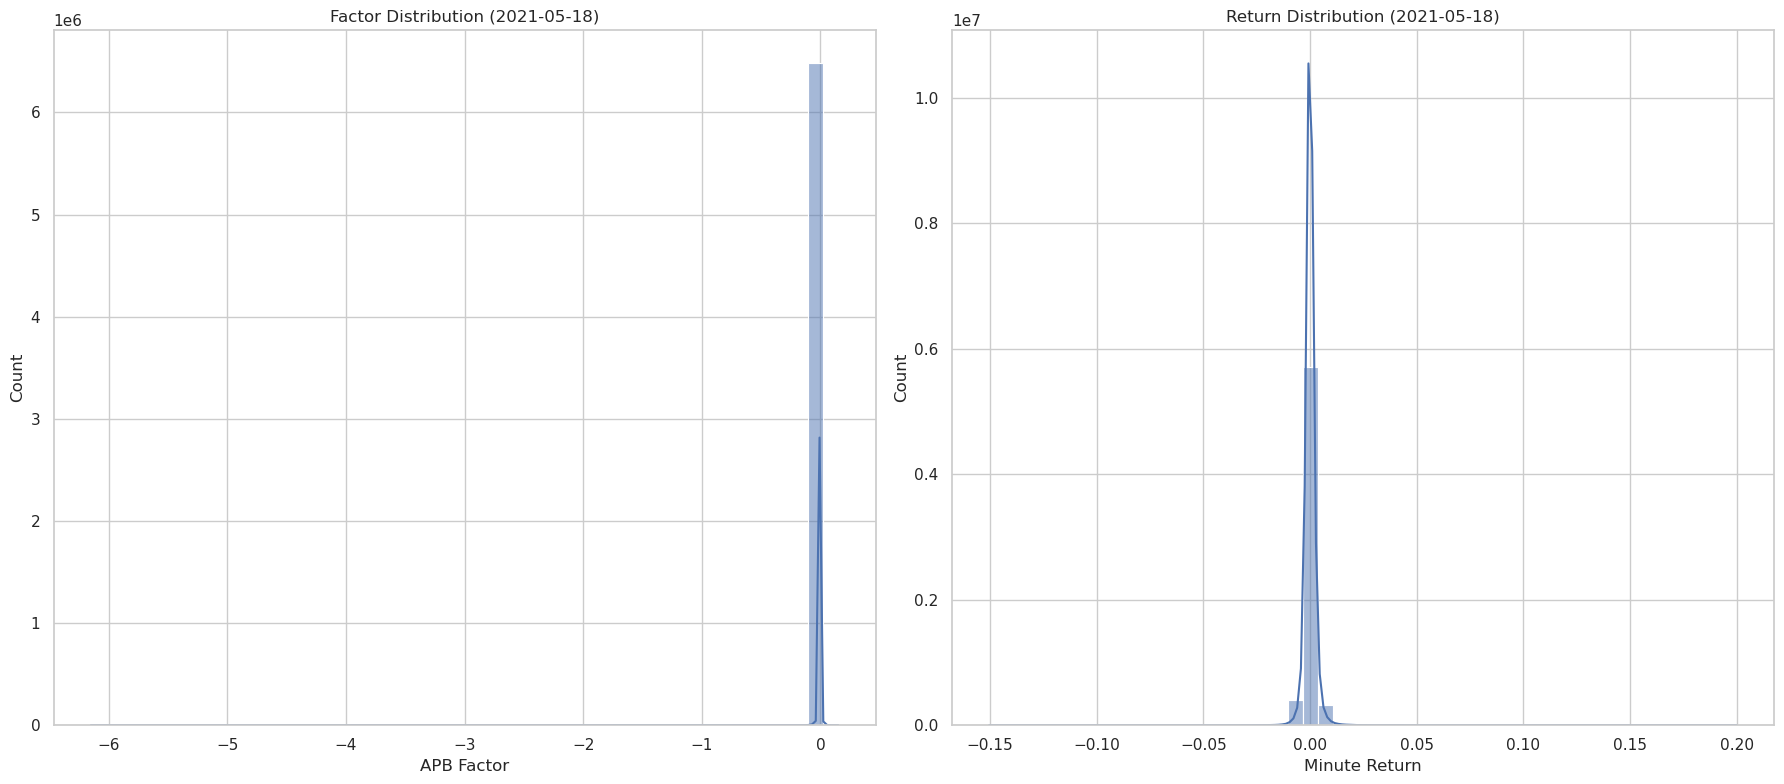

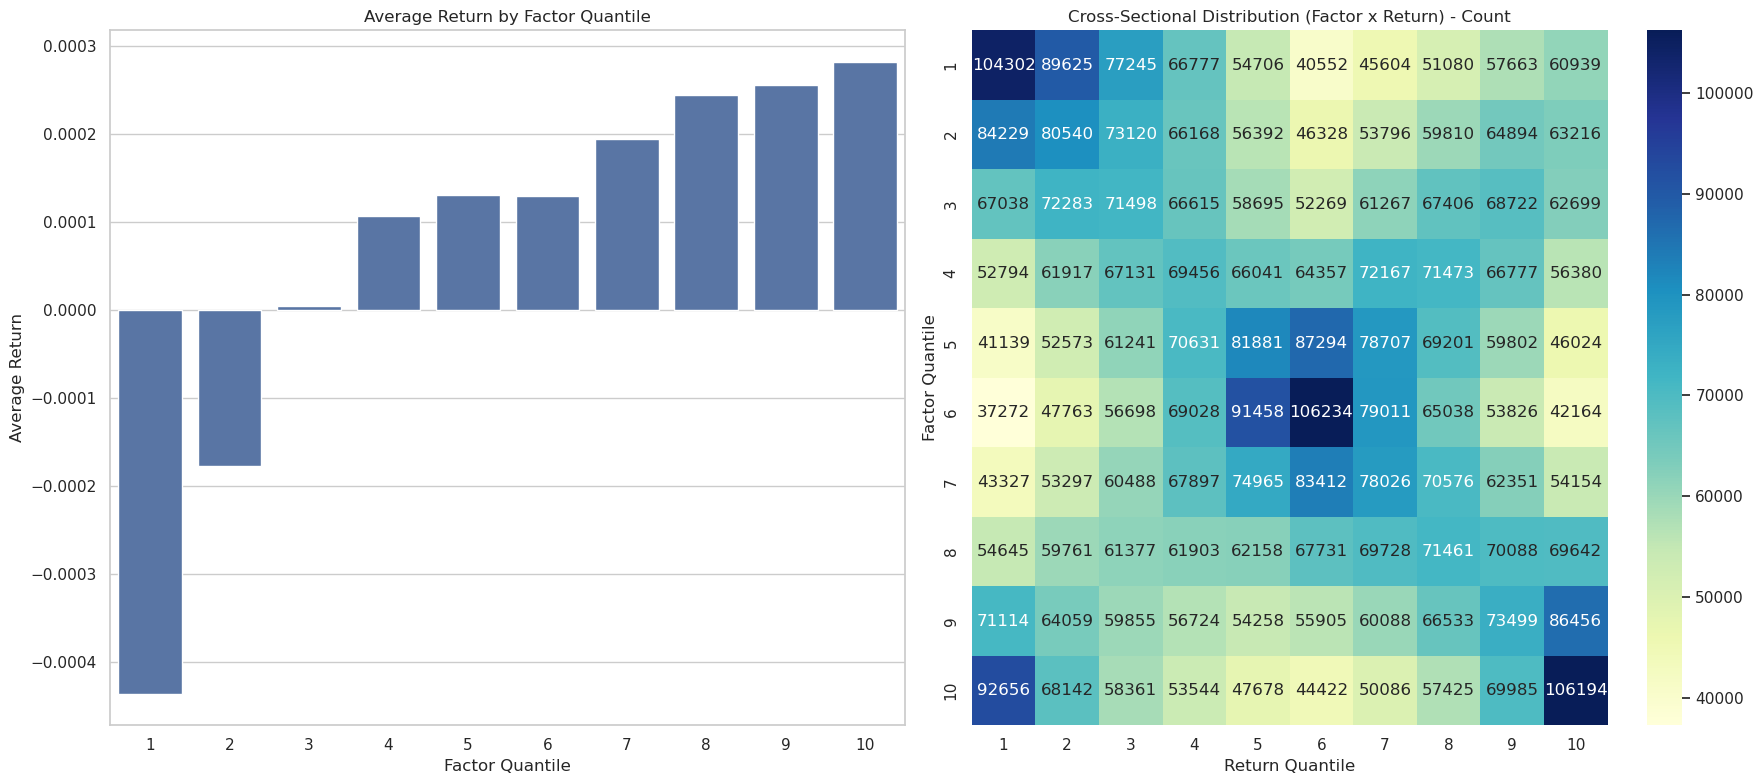

In [24]:
# date = '2021-05-18'
# df_day = df_clean[df_clean['trading_day'] == date].copy()

df_day = df_day.dropna(subset=['apb_p01_p99', 'minute_return'])
df_day = df_day[(df_day['apb_p01_p99'] != 0) & (df_day['minute_return'] != 0)]

df_day['apb_p01_p99'] = - df_day['apb_p01_p99']

print(f"2019-01-02数据样本量: {len(df_day)}")
print(f"证券数量: {df_day['security_code'].nunique()}")

# 基本统计信息
print("\n基本统计信息:")
print(df_day[['apb_p01_p99', 'minute_return']].describe())

# 计算相关性
corr = df_day[['apb_p01_p99', 'minute_return']].corr()
print("\n相关性矩阵:")
print(corr)

# 1. 分别按因子值和收益率进行5分组
df_day['factor_quantile'] = pd.qcut(df_day['apb_p01_p99'], 10, labels=False) + 1
df_day['return_quantile'] = pd.qcut(df_day['minute_return'], 10, labels=False) + 1

# 2. 创建10x10交叉分组表
cross_table = pd.crosstab(
    df_day['factor_quantile'], 
    df_day['return_quantile']
)  

print("\n交叉分组表 :")
print(cross_table)

# 3. 计算每个因子分组的平均收益率
factor_returns = df_day.groupby('factor_quantile')['minute_return'].agg(['mean', 'std', 'count'])
factor_returns['t_stat'] = factor_returns['mean'] / (factor_returns['std'] / np.sqrt(factor_returns['count']))
print("\n因子分组的平均收益率:")
print(factor_returns)

# 4. 计算最高分组与最低分组的收益率差异
top_minus_bottom = factor_returns.loc[5, 'mean'] - factor_returns.loc[1, 'mean']
print(f"\n最高分组与最低分组的收益率差异: {top_minus_bottom:.6f}")

# 5. 可视化

# 设置图表风格
sns.set(style="whitegrid")
plt.figure(figsize=(18, 8))

# 5.1 因子分布
plt.subplot(1, 2, 1)
sns.histplot(df_day['apb_p01_p99'], bins=50, kde=True)
plt.title(f'Factor Distribution ({date})')
plt.xlabel('APB Factor')

# 5.2 收益率分布
plt.subplot(1, 2, 2)
sns.histplot(df_day['minute_return'], bins=50, kde=True)
plt.title(f'Return Distribution ({date})')
plt.xlabel('Minute Return')

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 8))
# 5.3 因子分组平均收益率
plt.subplot(1, 2, 1)
sns.barplot(x=factor_returns.index, y=factor_returns['mean'])
plt.title('Average Return by Factor Quantile')
plt.xlabel('Factor Quantile')
plt.ylabel('Average Return')

# 5.4 交叉分组热力图
plt.subplot(1, 2, 2)
sns.heatmap(cross_table, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Cross-Sectional Distribution (Factor x Return) - Count')
plt.xlabel('Return Quantile')
plt.ylabel('Factor Quantile')

plt.tight_layout()
# plt.savefig(f'factor_analysis_{date}.png', dpi=300)
plt.show()

In [14]:
def derive_daily_minute_combined(trading_date):
    
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    factor_dir = f"/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Bid_percent_minute_level_APB/{date_str}.parquet"
    one_min_dir = f"/data/cephfs/minute/one_minute/{date_str}.parquet"

    df = pd.read_parquet(factor_dir)
    minute_ret = pd.read_parquet(one_min_dir)

    df['datetime'] = pd.to_datetime(df['order_minute'])
    df['start_time'] = df['datetime'].dt.hour * 100 + df['datetime'].dt.minute
    df['trading_day'] = pd.to_datetime(df['date'])

    minute_df = df[['trading_day','security_code','start_time','apb_p01_p99']]

    minute_ret = minute_ret[['security_code','trading_day','start_time','minute_return']]
    minute_ret['start_time'] = minute_ret['start_time'].astype(int)
    minute_ret['security_code'] = minute_ret['security_code'].astype(str)
    minute_ret['trading_day'] = pd.to_datetime(minute_ret['trading_day'])


    minute_df = minute_df.rename(columns={'date': 'trading_day'})
    minute_df['start_time'] = minute_df['start_time'].astype(int)
    minute_df['security_code'] = minute_df['security_code'].astype(str)
    minute_df['trading_day'] = pd.to_datetime(minute_df['trading_day'])

    merged_minute = pd.merge(
        minute_df,
        minute_ret,
        on=['security_code','trading_day','start_time'],
        how='outer'
    )


    return merged_minute

    

In [17]:
def process_single_date(trading_date, factor_name):
    
    """处理单个交易日的函数"""
   
    date_str = trading_date.strftime('%Y%m%d')
    output_dir = f"./factors/Minute_Ret_and_{factor_name}"
    file_path = f"{output_dir}/{date_str}.parquet"
    
    # 如果文件已存在，跳过处理
    if os.path.exists(file_path):
        print(f"文件已存在，跳过: {file_path}")
        return date_str, True, "已存在"
    
    # 检查原始数据文件是否存在
    data_file = f"/data/cephfs/minute/one_minute/{date_str}.parquet"
    if not os.path.exists(data_file):
        print(f"跳过日期 {date_str}: 原始数据文件不存在")
        return date_str, False, "数据文件不存在"
    
    try:
        daily_factor_df = derive_daily_minute_combined(trading_date)
        

        daily_factor_df.to_parquet(file_path, index=False)
        print(f"已生成因子文件: {file_path}")
        return date_str, True, "成功"
        
    except Exception as e:
        error_msg = str(e)
        print(f"处理日期 {date_str} 时出错: {error_msg}")
        return date_str, False, error_msg


def derive_daily_factor(start_date, end_date, factor_name, num_processes=30):
    start_time = time.time()
    
    trading_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 创建输出目录
    output_dir = f"./factors/Minute_Ret_and_{factor_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 创建进程池
    pool = mp.Pool(processes=num_processes)
    
    # 创建带有固定参数的处理函数
    process_date_with_args = partial(process_single_date, factor_name=factor_name)
    
    # 提交所有任务到进程池并获取结果
    print(f"开始使用 {num_processes} 个进程并行处理 {len(trading_dates)} 个交易日...")
    results = pool.map(process_date_with_args, trading_dates)
    
    # 关闭进程池
    pool.close()
    pool.join()
    
    # 分析处理结果
    processed_dates = [date_str for date_str, success, _ in results if success]
    skipped_dates = [date_str for date_str, success, _ in results if not success]
    
    # 打印处理结果摘要
    print(f"\n处理完成:")
    print(f"成功处理 {len(processed_dates)} 个日期")
    print(f"跳过 {len(skipped_dates)} 个日期")

    return output_dir


In [18]:
def main():

    start_date = '2019-01-01'
    end_date = '2025-05-31'

    factor_name = "Bid_percent_minute_APB"

    factor_dir = derive_daily_factor (start_date, end_date, factor_name)
    print(f"所有因子文件已生成在目录: {factor_dir}")

main()

跳过日期 20190101: 原始数据文件不存在跳过日期 20190302: 原始数据文件不存在跳过日期 20190210: 原始数据文件不存在跳过日期 20190501: 原始数据文件不存在跳过日期 20190720: 原始数据文件不存在跳过日期 20190630: 原始数据文件不存在跳过日期 20191117: 原始数据文件不存在跳过日期 20191207: 原始数据文件不存在跳过日期 20200405: 原始数据文件不存在


跳过日期 20190303: 原始数据文件不存在






跳过日期 20191208: 原始数据文件不存在跳过日期 20190721: 原始数据文件不存在跳过日期 20200406: 原始数据文件不存在跳过日期 20190502: 原始数据文件不存在



跳过日期 20190503: 原始数据文件不存在
跳过日期 20190504: 原始数据文件不存在
跳过日期 20190505: 原始数据文件不存在
跳过日期 20200425: 原始数据文件不存在
跳过日期 20200426: 原始数据文件不存在
开始使用 30 个进程并行处理 2343 个交易日...
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20190102.parquet
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20190610.parquet
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20190121.parquet
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20200116.parquet
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20190506.parquet
已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_APB/20190701.parquet已生成因子文件: ./factors/Minute_Ret_and_Bid_percent_minute_

In [4]:
from tqdm import tqdm  # 导入函数而不是模块


minute_dir = "/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Minute_Ret_and_Bid_percent_minute_APB"

parquet_pattern = os.path.join(minute_dir, "*.parquet")
parquet_files = glob.glob(parquet_pattern)

dfs = []
for file in tqdm(parquet_files, desc="读取parquet文件"):
    df = pd.read_parquet(file)
    dfs.append(df)

# 合并所有数据框
combined_df = pd.concat(dfs, ignore_index=True)
print(f"合并后的数据形状: {combined_df.shape}")


读取parquet文件:   0%|          | 0/1553 [00:00<?, ?it/s]

读取parquet文件: 100%|██████████| 1553/1553 [03:25<00:00,  7.55it/s]


合并后的数据形状: (1653156528, 5)


In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653156528 entries, 0 to 1653156527
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   trading_day    datetime64[ns]
 1   security_code  object        
 2   start_time     int64         
 3   apb_p01_p99    float64       
 4   minute_return  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 61.6+ GB


In [ ]:
import pandas as pd
import numpy as np
import os

# 假设数据框名为combined_df
# 1. 计算整体相关性
overall_correlation = combined_df['apb_p01_p99'].corr(combined_df['minute_return'])
print(f"整体相关性: {overall_correlation}")

# 2. 计算每天每只股票的相关性
print("开始计算每天每只股票的相关性...")

# 内存优化版本 - 逐日处理
all_correlations = []

# 获取唯一的交易日列表

unique_days = combined_df['trading_day'].unique()
total_days = len(unique_days)

for i, day in enumerate(unique_days):
    if i % 10 == 0:  # 每处理10天打印一次进度
        print(f"处理进度: {i}/{total_days} 天")
    
    # 只加载当天的数据
    day_data = combined_df[combined_df['trading_day'] == day]
    
    # 按股票代码分组计算相关性
    day_correlations = day_data.groupby('security_code').apply(
        lambda x: x['apb_p01_p99'].corr(x['minute_return']) if len(x) > 1 else np.nan
    ).reset_index(name='correlation')
    
    # 添加交易日列
    day_correlations['trading_day'] = day
    
    # 添加到结果列表
    all_correlations.append(day_correlations)
    
    # 清理内存
    del day_data
    
print("所有日期处理完毕，正在合并结果...")

# 合并所有结果
correlations = pd.concat(all_correlations, ignore_index=True)

# 重新排列列顺序
correlations = correlations[['trading_day', 'security_code', 'correlation']]

# 移除NaN值
correlations = correlations.dropna()

# 保存结果
output_path = "/data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_APB_AND_Minret.csv"
correlations.to_csv(output_path, index=False)

print(f"结果已保存到: {output_path}")

# 显示一些基本统计信息
print("\n相关性统计信息:")
print(correlations['correlation'].describe())

# 检查极端值
print("\n相关性极端值:")
print("最大正相关:", correlations.nlargest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])
print("最大负相关:", correlations.nsmallest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])

# 检查每天的平均相关性趋势
daily_avg_corr = correlations.groupby('trading_day')['correlation'].mean().reset_index()
print("\n每日平均相关性 (前5天和后5天):")
print("前5天:")
print(daily_avg_corr.head(20))
print("后5天:")
print(daily_avg_corr.tail(20))

# 确认文件已成功保存
if os.path.exists(output_path):
   
    print(f"\n文件已成功保存")
else:
    print("\n警告：文件可能未成功保存！")


整体相关性: -0.011749453063636015
开始计算每天每只股票的相关性...
处理进度: 0/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 10/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 20/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 30/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 40/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 50/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 60/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 70/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 80/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 90/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 560/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 570/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 580/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipyk

处理进度: 590/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 600/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 610/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 620/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 630/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 640/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 650/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 660/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 670/1553 天


/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

处理进度: 680/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 690/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 700/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 710/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 720/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 730/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 740/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 750/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 760/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 770/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 780/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 790/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 800/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 810/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 820/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 830/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 840/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 850/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 860/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 870/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 880/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 890/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 900/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 910/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 920/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 930/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 940/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 950/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 960/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 970/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 980/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 990/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1000/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1010/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1020/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1030/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1040/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1050/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1060/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1070/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1080/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1090/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipyk

处理进度: 1270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1326565/3065830921.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

所有日期处理完毕，正在合并结果...
结果已保存到: /data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_APB_AND_Minret.csv

相关性统计信息:
count    6.950742e+06
mean    -4.611957e-02
std      7.758975e-02
min     -1.000000e+00
25%     -9.307291e-02
50%     -4.448211e-02
75%      1.828474e-03
max      1.000000e+00
Name: correlation, dtype: float64

相关性极端值:
最大正相关:        trading_day security_code  correlation
27480   2021-03-30        603996          1.0
37041   2024-12-25        603421          1.0
37208   2024-12-25        603803          1.0
142716  2022-07-15        600781          1.0
329391  2023-09-11        603221          1.0
最大负相关:         trading_day security_code  correlation
303155   2024-08-26        600566         -1.0
962215   2022-04-11        600093         -1.0
1234943  2022-01-27        002188         -1.0
1260863  2020-02-03        600869         -1.0
1260974  2020-02-03        601107         -1.0

每日平均相关性 (前5天和后5天):
前5天:
   trading_day  correlation
0   2019-01-02    -0.040683
1   

In [8]:
file_path = "/data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_APB_AND_Minret.csv"

all_factor_data = pd.read_csv(file_path)

factor_names = ['correlation']

all_securities = all_factor_data['security_code'].unique()

# result_df = all_factor_data[['date', 'security_code']].copy()

for factor_name in factor_names:
    print(f"\n处理因子: {factor_name}")
    
    #转置成宽表
    pivot_data = all_factor_data.pivot(index='trading_day', columns='security_code', values=factor_name)

    # 对宽表直接应用rolling
    rolling_avg = pivot_data.rolling(window=20, min_periods=5).mean()

    # 将结果转换回长格式
    factor_df = rolling_avg.stack().reset_index()
    factor_df.columns = ['trading_day', 'security_code', factor_name]

    # 计算每日因子覆盖率
    # 计算每个日期非NaN的因子值数量
    non_nan_counts = factor_df.dropna(subset=[factor_name]).groupby('trading_day').size()

    # 计算覆盖率
    coverage = non_nan_counts / len(all_securities)
    print(f"\n{factor_name}因子覆盖率统计: 平均={coverage.mean():.2f}, 最小={coverage.min():.2f}")

    # result_df = pd.merge(
    #     result_df, 
    #     factor_df,
    #     on=['trading_day', 'security_code'],
    #     how='left'
    # )

output_path = "/data/home/lexuanchen/Factors/Order/Signal/20d_Corr_Min_Percent_Bid_APB_AND_Minret.csv"

factor_df.to_csv(output_path)



处理因子: correlation

correlation因子覆盖率统计: 平均=0.84, 最小=0.66


In [2]:
def derive_daily_apb_minute_grid_group(trading_date):
    """
    计算每个股票在给定交易日的APB与分钟收益率极值组合关系
    
    参数:
    trading_date - 交易日期
    
    返回:
    factor_df - 包含每个股票在该交易日的APB和分钟收益率极值组合的DataFrame
    """
    # 格式化日期字符串
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    factor_dir = f"./factors/Minute_Ret_and_Bid_percent_minute_APB/{date_str}.parquet"
    
    # 读取数据
    df = pd.read_parquet(factor_dir)
    
    # 数据清洗：去除空值并筛选交易时段 (9:30-14:57)
    df = df.dropna(subset=['apb_p01_p99', 'minute_return'])
    df = df[(df['start_time'] < 1457) & (df['start_time'] >= 930)]
    
    # 获取唯一的股票代码列表
    security_codes = df['security_code'].unique()
    
    # 创建结果DataFrame
    factor_df = pd.DataFrame({'security_code': security_codes})
    factor_df['date'] = pd.to_datetime(trading_date)
    
    # 初始化结果列
    high_apb_ret = []
    low_apb_ret = []
    high_min_apb = []
    low_min_apb = []
    
    # 对每个股票进行处理
    for security_code in security_codes:
        # 获取当前股票的数据
        stock_df = df[df['security_code'] == security_code].copy()
        
        if len(stock_df) < 48:  # 如果数据点少于48个，跳过或填充NaN
            high_apb_ret.append(np.nan)
            low_apb_ret.append(np.nan)
            high_min_apb.append(np.nan)
            low_min_apb.append(np.nan)
            continue
        
        # 按APB值排序，计算最高和最低组的平均分钟收益率
        stock_df_sorted_by_apb = stock_df.sort_values(by='apb_p01_p99', ascending=False)
        high_apb_group = stock_df_sorted_by_apb.head(48)  # 取APB最高的48个分钟
        low_apb_group = stock_df_sorted_by_apb.tail(48)   # 取APB最低的48个分钟
        
        # 计算高APB组和低APB组的平均分钟收益率
        high_apb_ret.append(high_apb_group['minute_return'].mean())
        low_apb_ret.append(low_apb_group['minute_return'].mean())
        
        # 按分钟收益率排序，计算最高和最低组的平均APB值
        stock_df_sorted_by_ret = stock_df.sort_values(by='minute_return', ascending=False)
        high_ret_group = stock_df_sorted_by_ret.head(48)  # 取分钟收益率最高的48个分钟
        low_ret_group = stock_df_sorted_by_ret.tail(48)   # 取分钟收益率最低的48个分钟
        
        # 计算高分钟收益率组和低分钟收益率组的平均APB值
        high_min_apb.append(high_ret_group['apb_p01_p99'].mean())
        low_min_apb.append(low_ret_group['apb_p01_p99'].mean())
    
    # 将结果添加到DataFrame
    factor_df['high_apb'] = high_apb_ret
    factor_df['low_apb'] = low_apb_ret
    factor_df['high_min'] = high_min_apb
    factor_df['low_min'] = low_min_apb
    
    return factor_df


In [3]:
def process_single_date(trading_date, factor_name):
    
    """处理单个交易日的函数"""
   
    date_str = trading_date.strftime('%Y%m%d')
    output_dir = f"./factors/{factor_name}"
    file_path = f"{output_dir}/{date_str}.parquet"
    
    # 如果文件已存在，跳过处理
    if os.path.exists(file_path):
        print(f"文件已存在，跳过: {file_path}")
        return date_str, True, "已存在"
    
    # 检查原始数据文件是否存在
    data_file = f"./factors/Minute_Ret_and_Bid_percent_minute_APB/{date_str}.parquet"
    if not os.path.exists(data_file):
        print(f"跳过日期 {date_str}: 原始数据文件不存在")
        return date_str, False, "数据文件不存在"
    
    try:
        daily_factor_df = derive_daily_apb_minute_grid_group(trading_date)
        
        daily_factor_df['date'] = date_str

        daily_factor_df.to_parquet(file_path, index=False)
        print(f"已生成因子文件: {file_path}")
        return date_str, True, "成功"
        
    except Exception as e:
        error_msg = str(e)
        print(f"处理日期 {date_str} 时出错: {error_msg}")
        return date_str, False, error_msg


def derive_daily_factor(start_date, end_date, factor_name, num_processes=20):
    start_time = time.time()
    
    trading_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 创建输出目录
    output_dir = f"./factors/{factor_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 创建进程池
    pool = mp.Pool(processes=num_processes)
    
    # 创建带有固定参数的处理函数
    process_date_with_args = partial(process_single_date, factor_name=factor_name)
    
    # 提交所有任务到进程池并获取结果
    print(f"开始使用 {num_processes} 个进程并行处理 {len(trading_dates)} 个交易日...")
    results = pool.map(process_date_with_args, trading_dates)
    
    # 关闭进程池
    pool.close()
    pool.join()
    
    # 分析处理结果
    processed_dates = [date_str for date_str, success, _ in results if success]
    skipped_dates = [date_str for date_str, success, _ in results if not success]
    
    # 打印处理结果摘要
    print(f"\n处理完成:")
    print(f"成功处理 {len(processed_dates)} 个日期")
    print(f"跳过 {len(skipped_dates)} 个日期")

    return output_dir


In [4]:
def calculate_rolling_20d_avg(factor_names, factor_dir, start_date=None, end_date=None, min_window=5):
    
    if not isinstance(factor_names, list):
        factor_names = [factor_names]
    
    parquet_pattern = os.path.join(factor_dir, "*.parquet")
    parquet_files = glob.glob(parquet_pattern)
    print(f"在目录 {factor_dir} 中找到 {len(parquet_files)} 个Parquet文件")
    

    conn = duckdb.connect(database=':memory:')
    all_factor_data = conn.execute(f"""
        SELECT * FROM read_parquet('{parquet_pattern}')
    """).fetchdf()
    conn.close()
    

    missing_factors = [f for f in factor_names if f not in all_factor_data.columns]
    if missing_factors:
        raise ValueError(f"在Parquet文件中未找到以下因子列: {', '.join(missing_factors)}")
    
    all_factor_data['date'] = pd.to_datetime(all_factor_data['date'])

    all_factor_data = all_factor_data.sort_values(['date', 'security_code'])
    
    # 筛选日期范围
    if start_date:
        start_date = pd.to_datetime(start_date)
        all_factor_data = all_factor_data[all_factor_data['date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        all_factor_data = all_factor_data[all_factor_data['date'] <= end_date]

    # 获取所有个股代码
    all_securities = all_factor_data['security_code'].unique()

    result_df = all_factor_data[['date', 'security_code']].copy()

    # 为每个因子计算滚动平均
    for factor_name in factor_names:
        print(f"\n处理因子: {factor_name}")
        
        #转置成宽表
        pivot_data = all_factor_data.pivot(index='date', columns='security_code', values=factor_name)

        # 对宽表直接应用rolling
        rolling_avg = pivot_data.rolling(window=20, min_periods=min_window).mean()

        # 将结果转换回长格式
        factor_df = rolling_avg.stack().reset_index()
        factor_df.columns = ['date', 'security_code', factor_name]

        # 计算每日因子覆盖率
        # 计算每个日期非NaN的因子值数量
        non_nan_counts = factor_df.dropna(subset=[factor_name]).groupby('date').size()

        # 计算覆盖率
        coverage = non_nan_counts / len(all_securities)
        print(f"\n{factor_name}因子覆盖率统计: 平均={coverage.mean():.2f}, 最小={coverage.min():.2f}")

        result_df = pd.merge(
            result_df, 
            factor_df,
            on=['date', 'security_code'],
            how='left'
        )
    
    return result_df

In [5]:
def main():

    start_date = '2019-01-01'
    end_date = '2025-05-31'

    factor_name = "Grid_Group_Percent_Bid_APB_AND_Minret"
    
    factor_dir = derive_daily_factor (start_date, end_date, factor_name)
    print(f"所有因子文件已生成在目录: {factor_dir}")

    factors = ['high_apb','low_apb','high_min','low_min']

    result_df = calculate_rolling_20d_avg(factors, factor_dir, start_date, end_date, min_window=5)
    
    # 保存结果为CSV
    output_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Bid_APB_AND_Minret"
    os.makedirs(output_path, exist_ok=True)

    result_df.to_csv(f'{output_path}/All_Grid_Group_Percent_Bid_APB_AND_Minret.csv')

    print(f"共计 {len(result_df)} 条记录")

    print("\n数据预览:")
    print(result_df.head())

# 执行主函数
if __name__ == "__main__":
    main()


文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190131.parquet文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190531.parquet跳过日期 20190101: 原始数据文件不存在文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191028.parquet跳过日期 20190302: 原始数据文件不存在文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190401.parquet文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191127.parquet文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190829.parquet文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191227.parquet跳过日期 20190928: 原始数据文件不存在


文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20200326.parquet跳过日期 20200126: 原始数据文件不存在文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20200225.parquet


跳过日期 20200425: 原始数据文件不存在文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191029.parquet


文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190201.parquet
文件已存在，跳过: ./factors/Grid_Group_Percent_Bid_APB_AND_Minre

开始使用 20 个进程并行处理 2343 个交易日...
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190212.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190509.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190704.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190404.parquet
跳过日期 20190405: 原始数据文件不存在
跳过日期 20190406: 原始数据文件不存在
跳过日期 20190407: 原始数据文件不存在
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190307.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191010.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20190903.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20191031.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20200102.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Bid_APB_AND_Minret/20200430.parquet
跳过日期 20200501: 原始数据文件不存在
跳过日期 20200502: 原始数据文件不存在
跳过日期 20200503: 原始数据文件不存在
跳过日期 20200504: 原始数据文件不存在
跳过日期 20200505: 原始数据文件不存在
已生成因子文件: ./factors/Grid_Group_P

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


处理因子: high_apb

high_apb因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: low_apb

low_apb因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: high_min

high_min因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: low_min

low_min因子覆盖率统计: 平均=0.84, 最小=0.66
共计 6974952 条记录

数据预览:
        date security_code  high_apb  low_apb  high_min  low_min
0 2019-01-02        000001       NaN      NaN       NaN      NaN
1 2019-01-02        000002       NaN      NaN       NaN      NaN
2 2019-01-02        000004       NaN      NaN       NaN      NaN
3 2019-01-02        000005       NaN      NaN       NaN      NaN
4 2019-01-02        000006       NaN      NaN       NaN      NaN


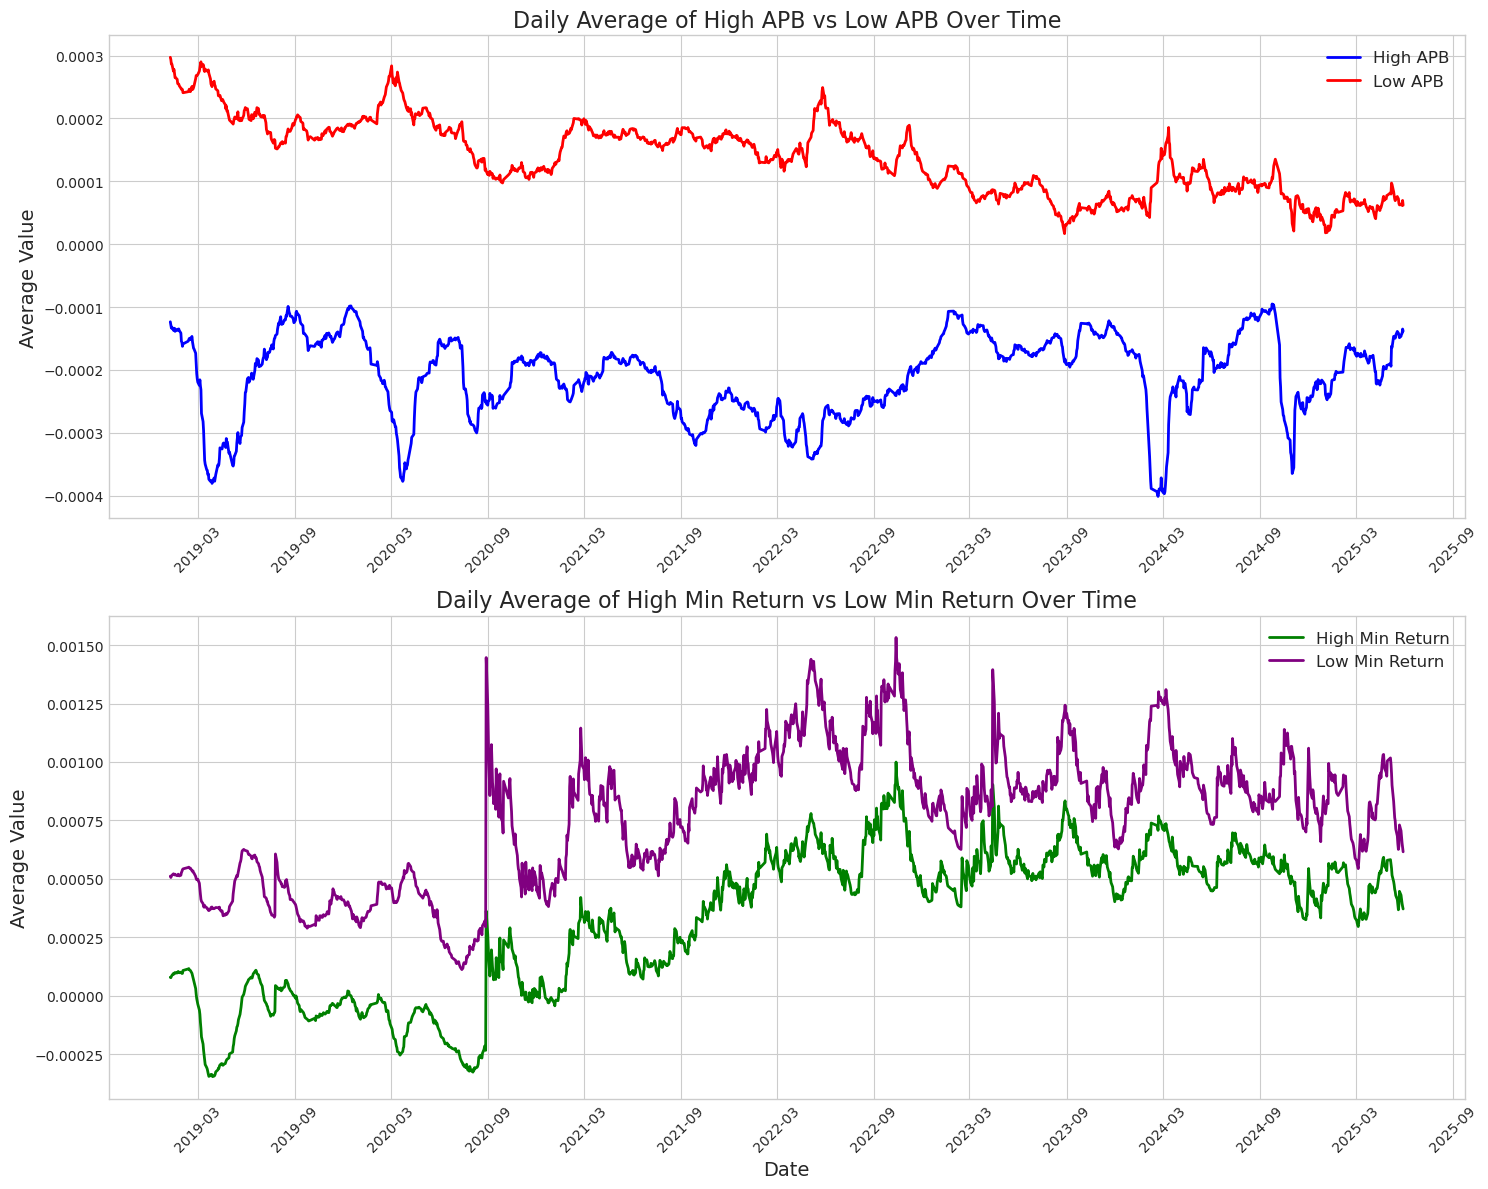

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime


# 保存结果为CSV
output_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Bid_APB_AND_Minret"

result_df = pd.read_csv(f'{output_path}/All_Grid_Group_Percent_Bid_APB_AND_Minret.csv')

# 计算每个日期每个因子的均值
daily_means = result_df.groupby('date')[['high_apb', 'low_apb', 'high_min', 'low_min']].mean().reset_index()

# 确保日期列是datetime类型
daily_means['date'] = pd.to_datetime(daily_means['date'])

# 设置图形大小和风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 12))

# 创建第一个子图: high_apb和low_apb
plt.subplot(2, 1, 1)
plt.plot(daily_means['date'], daily_means['high_apb'], label='High APB', color='blue', linewidth=2)
plt.plot(daily_means['date'], daily_means['low_apb'], label='Low APB', color='red', linewidth=2)

# 设置x轴日期格式，每半年显示一次
ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 每6个月显示一次
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('Daily Average of High APB vs Low APB Over Time', fontsize=16)
plt.ylabel('Average Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# 创建第二个子图: high_min和low_min
plt.subplot(2, 1, 2)
plt.plot(daily_means['date'], daily_means['high_min'], label='High Min Return', color='green', linewidth=2)
plt.plot(daily_means['date'], daily_means['low_min'], label='Low Min Return', color='purple', linewidth=2)

# 设置x轴日期格式，每半年显示一次
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 每6个月显示一次
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('Daily Average of High Min Return vs Low Min Return Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# 调整布局，确保图形不会重叠
plt.tight_layout()

# 显示图形
plt.savefig('apb_time_series.png', dpi=300, bbox_inches='tight')
plt.show()


In [1]:
import pandas as pd
import numpy as np

output_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Bid_APB_AND_Minret"

result_df = pd.read_csv(f'{output_path}/All_Grid_Group_Percent_Bid_APB_AND_Minret.csv')

factors = ['high_apb','low_apb','high_min','low_min']

for factor in factors:

    df = result_df[['date','security_code',factor]].copy()

    df.to_csv(f"{output_path}/20d_{factor}.csv")

In [8]:
from tqdm import tqdm  # 导入函数而不是模块
# import pandas as pd
import glob
import os


minute_dir = "/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Grid_Group_Percent_Bid_APB_AND_Minret"

parquet_pattern = os.path.join(minute_dir, "*.parquet")
parquet_files = glob.glob(parquet_pattern)

dfs = []
for file in tqdm(parquet_files, desc="读取parquet文件"):
    df = pd.read_parquet(file)
    dfs.append(df)

# 合并所有数据框
combined_df = pd.concat(dfs, ignore_index=True)
print(f"合并后的数据形状: {combined_df.shape}")


读取parquet文件: 100%|██████████| 1553/1553 [00:59<00:00, 26.06it/s]

合并后的数据形状: (6974952, 6)


In [9]:
combined_df.head()

,security_code,date,high_apb,low_apb,high_min,low_min
0,000001,20240312,0.000239,-0.000178,-0.004457,-0.005653
1,000002,20240312,-0.000522,0.000202,-0.000574,-0.000008
2,000004,20240312,-0.000567,0.000313,-0.005606,-0.003011
3,000006,20240312,-0.000044,-0.000261,0.000907,0.001587
4,000007,20240312,-0.000379,0.000663,0.000312,0.001054


In [10]:
for factor in factors:

    df = combined_df[['date','security_code',factor]].copy()

    df.to_csv(f"{output_path}/Raw_{factor}.csv")

In [4]:
# 1. 计算整体相关性
overall_correlation = combined_df['ask_price_divergence_p01p99'].corr(combined_df['minute_return'])
print(f"整体相关性: {overall_correlation}")

# 2. 计算每天每只股票的相关性
print("开始计算每天每只股票的相关性...")

# 内存优化版本 - 逐日处理
all_correlations = []

# 获取唯一的交易日列表

unique_days = combined_df['trading_day'].unique()
total_days = len(unique_days)

for i, day in enumerate(unique_days):
    if i % 10 == 0:  # 每处理10天打印一次进度
        print(f"处理进度: {i}/{total_days} 天")
    
    # 只加载当天的数据
    day_data = combined_df[combined_df['trading_day'] == day]
    
    # 按股票代码分组计算相关性
    day_correlations = day_data.groupby('security_code').apply(
        lambda x: x['ask_price_divergence_p01p99'].corr(x['minute_return']) if len(x) > 1 else np.nan
    ).reset_index(name='correlation')
    
    # 添加交易日列
    day_correlations['trading_day'] = day
    
    # 添加到结果列表
    all_correlations.append(day_correlations)
    
    # 清理内存
    del day_data
    
print("所有日期处理完毕，正在合并结果...")

# 合并所有结果
correlations = pd.concat(all_correlations, ignore_index=True)

# 重新排列列顺序
correlations = correlations[['trading_day', 'security_code', 'correlation']]

# 移除NaN值
correlations = correlations.dropna()

# 保存结果
output_path = "/data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Ask_Price_Divergence_AND_Minret.csv"
correlations.to_csv(output_path, index=False)

print(f"结果已保存到: {output_path}")

# 显示一些基本统计信息
print("\n相关性统计信息:")
print(correlations['correlation'].describe())

# 检查极端值
print("\n相关性极端值:")
print("最大正相关:", correlations.nlargest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])
print("最大负相关:", correlations.nsmallest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])

# 检查每天的平均相关性趋势
daily_avg_corr = correlations.groupby('trading_day')['correlation'].mean().reset_index()
print("\n每日平均相关性 (前5天和后5天):")
print("前5天:")
print(daily_avg_corr.head(20))
print("后5天:")
print(daily_avg_corr.tail(20))

# 确认文件已成功保存
if os.path.exists(output_path):
   
    print(f"\n文件已成功保存")
else:
    print("\n警告：文件可能未成功保存！")


整体相关性: 0.04731180885271494
开始计算每天每只股票的相关性...
处理进度: 0/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 10/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 20/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 30/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 40/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 50/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 60/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 70/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 80/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 90/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 560/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 570/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 580/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 590/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 600/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 610/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 620/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 630/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 640/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 650/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 660/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 670/1553 天


/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

处理进度: 680/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 690/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 700/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 710/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 720/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 730/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 740/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 750/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 760/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 770/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 780/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 790/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 800/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 810/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 820/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 830/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 840/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 850/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 860/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 870/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 880/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 890/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 900/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 910/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 920/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 930/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 940/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 950/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 960/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 970/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 980/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 990/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1000/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1010/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1020/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1030/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1040/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1050/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1060/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1070/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1080/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1090/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2164732/2109425933.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

所有日期处理完毕，正在合并结果...
结果已保存到: /data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Ask_Price_Divergence_AND_Minret.csv

相关性统计信息:
count    6.950482e+06
mean     5.916862e-02
std      9.297711e-02
min     -1.000000e+00
25%     -1.519876e-04
50%      5.691446e-02
75%      1.154282e-01
max      1.000000e+00
Name: correlation, dtype: float64

相关性极端值:
最大正相关:       trading_day security_code  correlation
13174  2023-11-01        603929          1.0
26245  2021-03-30        600339          1.0
31657  2024-03-15        603011          1.0
37150  2024-12-25        603686          1.0
54892  2019-06-26        603111          1.0
最大负相关:         trading_day security_code  correlation
883664   2024-05-06        600165         -1.0
1171945  2019-07-26        600666         -1.0
1183431  2022-05-17        600734         -1.0
2648967  2021-02-22        600540         -1.0
3498122  2024-03-21        603002         -1.0

每日平均相关性 (前5天和后5天):
前5天:
   trading_day  correlation
0   2019-01-02     0.0223